# Basic Intro

* BERT - Bidirectional Encoder Representations from Transformer
* It was developed by Google AI in 2018 and jointly conditions on both left and right context. This mean unlike older models that read text left-to-right or right-to-left, **BERT reads in both directions simultaneously**.
* As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create models for a wide range of NLP tasks.

## Why BERT?

* Context-free models such as **word2vec** or **GloVe** generate a **single word embedding representation** for each word in the vocabulary.
* BERT, as a contextual model, can capture different meanings of a word in a bidirectional way.

**Working of BERT**,

| Step | Description | Example |
| :- | -: | :-: |
| 1 | Input Text | my dog likes playing.
| 2 | Tokenization - [WordPiece](https://www.youtube.com/watch?v=qpv6ms_t_1A&t=11s) | [CLS], my, dog, likes, play, ##ing, [SEP]
| 3 | Vectorization | Token embeddings + Segment embeddings + Position embeddings
| 4 | Pre-training Task 1 | Masked Language Modelling; [MASK]
| 5 | Pre-training Task 2 | Next sentence prediction; IsNext v/s NotNext

## BERT Implementation

### Spam v/s Ham Detection

#### Import Libraries and Dataset

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [25]:
# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
import torch

# Check if PyTorch is using the GPU
print("Is CUDA available? ", torch.cuda.is_available())
if device == "cuda":
    print("Device name: ", torch.cuda.get_device_name(0))

Is CUDA available?  True


In [27]:
df = pd.read_csv("/kaggle/input/spamdata-v2/spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### Splitting Dataset

In [28]:
# Keeping 70% of data for training and 30% for testing + validation
### stratify will ensure that the splitted data has same proportion of spam and ham
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


# Now, using the 30% data obtained from previous line to split in 
# 50% test and 50% validation
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, stratify=temp_labels)

#### Basic EDA ???

In [29]:
# check class distribution
df['label'].value_counts(normalize = True)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

<Axes: >

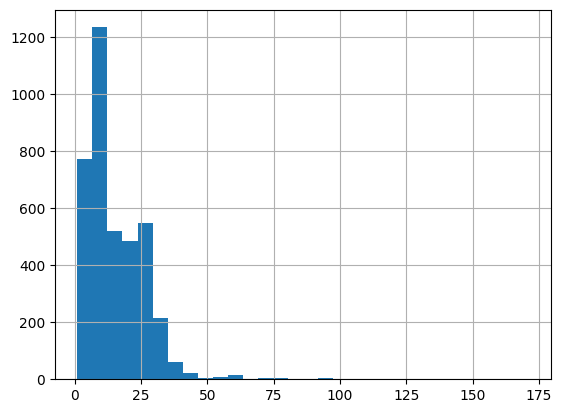

In [30]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

#### Import BERT - base and uncased

In [31]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

#### Tokenization

* BERT uses **WordPiece** tokenization.
* maximum sequence length of the input = 512. This means you cannot feed more than 512 tokens into BERT at once.
* In below code, we are keeping maximum tokens generated per sequence to 25, and is padded if short or truncated if exceeds.

In [32]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


* Output of batch_encode_plus is a dictionary with following keys,
  * input_ids: list of token IDs
  * token_type_ids: used in tasks like sentence pair classification
  * attention_mask: indicates which tokens are real tokens and which are padding tokens(0)
* It is to be noted that in our case, for example, train_text has 3900 samples. Hence, input_ids will be a list of 3900 elements. Each element in this list will be another list of 25 elements (corresponding to max_length argument provided to batch_encode_plus).
* **Attention masks** is a binary list that tells BERT which tokens are real and which are just padding.
  * **And why is this needed?** --> BERT operates on fixed-length input sequences (like 25 or 512 tokens). To make every input the same length, we pad shorter sequences with special [PAD] tokens. But we don’t want the model to pay attention to the padding — it’s meaningless. That’s where the attention mask comes in. 

#### Convert List to Tensors

In [33]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

#### Data Loader

* This section prepares the input data for batching and feeding into the model efficiently during training and validation.

In [34]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, 
                              sampler=train_sampler, 
                              batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during validation
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, 
                            sampler = val_sampler, 
                            batch_size=batch_size)

In [35]:
train_data[0]

(tensor([ 101, 2035, 2097, 2272, 4142, 1012, 2488, 6149, 2151, 2204, 2559, 3275,
         2045, 2993, 1012, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
            0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0]),
 tensor(0))

#### Model Architecture

In [36]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

Now, we have following tasks in front,
* We have BERT pre-trained model and we have frozen its parameters. This means the parameters will not be updated during back propagation.
* We will add few fully connected layers to BERT.
* Add classifier of spam or ham.

In the new addition to architecture,
* ensure that FC1 layer has 768 input size because BERT gives vector of 768 values for each sentence ([CLS] token).

In [37]:
# nn.Module is the base class for all neural networks in PyTorch
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert     # this is the frozen BERT
        
        # dropout layer - randomly disables 10% of neurons during training
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [38]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [39]:
model

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

* Next we will define an **optimizer - AdamW**
* Its a variant of Adam optimizer, and adds weight decay for better regularization.
* Optimizer controls how model's weights are updated during training.
* For this,
  * We give acccess to model's weights.
  * and tell the optimizer what learning rate it has to adopt.

In [40]:
# optimizer from hugging face transformers
#from transformers import AdamW
from torch.optim import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

Formula used internaally, $$\text{Weight}_{\text{class}}=\frac{n_{\text{samples}}}{n_{\text{class}}*n_{\text{samples in class}}}$$ 

In [41]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(train_labels), 
                                     y = train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


In [42]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights, dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

#### Fine Tuning the Model

| Concept                | Explanation                                                                     |
|------------------------|--------------------------------|
| `model.train()`        | Sets model to training mode. Enables layers like Dropout and BatchNorm.     |
| `zero_grad()`          | Clears old gradients before backpropagation.                                |
| `loss.backward()`      | Computes gradients via backpropagation.                                     |
| `optimizer.step()`     | Updates model weights using computed gradients.                             |
| `clip_grad_norm_`      | Prevents exploding gradients by limiting their norm to a max value (e.g., 1).|
| `detach().cpu().numpy()`| Detaches tensors from GPU and graph for CPU-based post-processing.          |
| `cross_entropy(...)`   | Computes weighted loss for classification using class imbalance handling.   |


In [43]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [44]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches

    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [45]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.668
Validation Loss: 0.646

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.636
Validation Loss: 0.614

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.611
Validation Loss: 0.587

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.588
Validation Loss: 0.566

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.563
Validation Loss: 0.538

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.545
Validation Loss: 0.514

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.520
Validation Loss: 0.495

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.505
Validat

In [46]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Making Predictions now

In [47]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [48]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       724
           1       0.49      0.84      0.62       112

    accuracy                           0.86       836
   macro avg       0.73      0.85      0.77       836
weighted avg       0.91      0.86      0.87       836

